# Marketing Campaign Performance Analysis with Python

## Contents
* [Dataset](#dataset)
* [Preprocessing](#pre)
    * [Initial exploratory analysis](#iea)
        * [How many unique users saw marketing assets by date?](#iea-find)
* [Exploratory Analysis and Summary Statistics](#eass)
* [Segmentation](#seg)
    * [How many subscribers were gained by each channel?](#subs-channel-list)
    * [How many customers did each channel retain?](#cust-channel-retain)
    * [What are the conversions rates for each channel?](#conv-rate-channel-list)
    * [What are the retention rates for each channel?](#reten-rate-channel-list)
    * [What is the conversion rate for English speakers?](#conv-rate-eng)
    * [How does the English conversion rate compare against the other 3 languages?](#conv-rate-lang)
    * [Overall daily conversion rate](#overall-daily-conv-plot)
    * [Overall daily subscriber quality (retention)](#overall-daily-reten)
    * [Daily language preferrences](#daily-lang-pref)
    * [Are marketing channels reaching all age groups?](#channel-age)
* [Conversion Attribution by Segements](#conv-attr-seg)
    * [Day of week conversion trends](#dow)
    * [Daily conversion rates by age group](#daily-conv-age)
    * [Daily conversion rates by language](#daily-conv-lang)
    * [Daily conversion rates by channel](#ads-drop)
* [Inconsistencies](#incon)
    * [Identifying the cause of inconsistencies](#cause)
        * [House Ads English conversion rate drop](#eng-conv-drop)
        * [Percentage of users served ads in the correct language](#ads_correct_lang)
    * [Calculate the impact of the error](#impact)

## Dataset <a class="anchor" id="dataset"></a>

Assess the contents and quality of the dataset.

In [2]:
# Import libraries and submodules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import dataset from Marketing CSV file and pass a list of column names to the parse_dates argument to ensure that these columns are correctly interpreted as date columns.

marketing = pd.read_csv('marketing.csv')

In [4]:
# Inspect the dataset
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [5]:
# Generate statistics descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

marketing.describe()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
count,10037,10021,10022,10037,10022,10037,10037,10037,1856,577,1856,1856
unique,7309,31,5,2,2,4,4,7,31,115,5,2
top,a100000882,1/15/18,House Ads,control,False,English,English,19-24 years,1/16/18,4/2/18,Instagram,True
freq,12,789,4733,5091,8946,9793,9275,1682,163,15,600,1279


No obvious errors in the data.

There are 10,037 rows of data but only 7,309 unique users marketed to over the month of January 2018 via 5 different channels, with 2 A/B test variations (control and personalization), in 4 different languages and across an audience of 7 different age groups. Lastly, there are 2 Boolean (True, False) columns.

In [6]:
# Identify data types and missing values
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB


Date columns are incorrectly object data types, they should be datetime.

Columns `converted` and `is_retained` should be the boolean data type. `converted` has no null values, while `is_retained` has 8,181 null values (empty cells).

---

## Preprocessing <a class="anchor" id="pre"></a>

Fixing data types and Feature Engineering

### Fix data types

Having incorrect data types will hinder Python's ability to manipulate your data, which will hinder your analysis.

In [7]:
# Change data type for date columns to datetime
marketing['date_served'] = pd.to_datetime(marketing['date_served'])
marketing['date_subscribed'] = pd.to_datetime(marketing['date_subscribed'])
marketing['date_canceled'] = pd.to_datetime(marketing['date_canceled'])


# Check the data types are is now datetime
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


In [8]:
# Change data type for 'converted' to boolean
marketing['converted'] = marketing['converted'].astype('bool')

# Check the data type is now boolean
marketing['converted'].dtype

dtype('bool')

For the `is_retained` column, you have 8,181 null values. pandas will fill all these empty cells with True, which will add an extra 8,181 retained clients in our calculations. To avoid this, fill NaN values with False before converting the column to boolean.

In [9]:
# Fill NaN values with False, then change data type for 'converted' to boolean
marketing['is_retained'] = marketing['is_retained'].fillna(False).astype(bool)

# Check the data type is now boolean, and that there are 10,037 non-null values
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10037 non-null  bool          
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          10037 non-null  bool          
dtypes: bool(2), datetime64[ns](3), object(7)
memory usage: 803.9+ KB


### Feature Engineering

This involves having the foresight from your domain knowledge to engineer new columns that will enable a more in-depth analysis.

1. In marketing, it's very useful to identify weekly conversions trends. Are users more likely to convert during the week or over the weekend? Creating a new column to map the date users subscribed to a numerical value respresenting the day of the week will enable you to answer this so that you can recommend best practices for future campaigns. It's computationally more efficient to store this column as numbers instead of strings i.e. Monday.

2. When you're marketing in multiple languages, things can get complicated and are therefore error-prone. You want to create a new column to check if users were marketed to in their preferred language.

3. It's also handy to map marketing channels to numerical values.

In [10]:
# 1. Create a new column from the 'date_subscribed' column that maps each day of the week to a numerical value i.e. Monday to 0, Tuesday to 1, etc.
marketing['DoW'] = marketing['date_subscribed'].dt.dayofweek


# Check new column was added to the end of the DataFrame
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True,0.0
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True,0.0


In [11]:
# 2. Create a new column 'is_correct_lang' that returns "Yes" if columns 'language_preferred' and 'language_displayed' are the same, and "No" if not
marketing['is_correct_lang'] = np.where(marketing['language_preferred'] == marketing['language_displayed'], "Yes", "No")


# Check new column was added to the end of the DataFrame
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,is_correct_lang
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0,Yes
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0,Yes
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0,Yes
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True,0.0,Yes
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True,0.0,Yes


In [12]:
# 3. Create new column that maps 'subscribing_channel' column to a numerical scale using "channel_dict" dictionary

# Channel dictionary
channel_dict = {"House Ads":1, "Instagram":2, "Facebook":3, "Email":4, "Push":5}

# Map dictionary to new column "channel_code"
marketing['channel_code'] = marketing['subscribing_channel'].map(channel_dict)

# Check new column was added to the end of the DataFrame
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,is_correct_lang,channel_code
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0


---

### Initial exploratory analysis <a class="anchor" id="iea"></a>

#### How many unique users saw marketing assets by date?

This is crucial to get a good overview of the trend and fluctuations of your marketing efforts over the past month.

The `groupby()` method is perfect for this. To group by date, we pass `date_served` as the argument to `groupby()`. Next, we select the `user_id` column outside of the `groupby()` and use `nunique()` method to count the number of unique users each day. 

In [13]:
# Aggregate unique users that saw marketing assets by date
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()

# Check first 5 results
daily_users.head()

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
Name: user_id, dtype: int64

It's very difficult to draw any useful conclusions from a long list of numbers. Visualising your metrics make it much esaier to spot fluctiations and trends.

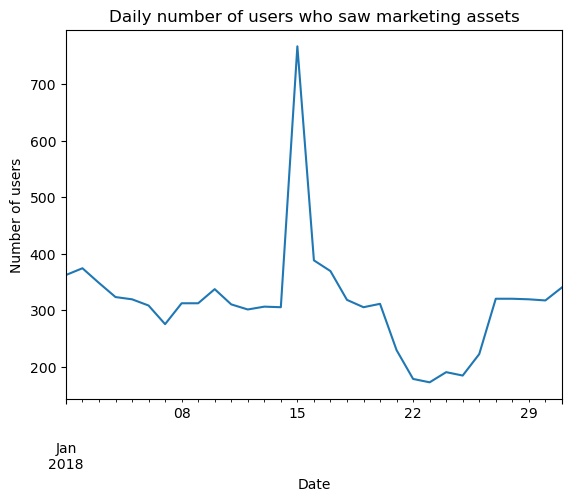

In [14]:
# Plot the series daily_users with Matplotlib Pyplot
daily_users.plot()

# Annotate the plot
plt.title('Daily number of users who saw marketing assets')
plt.xlabel('Date')
plt.ylabel('Number of users')

# Show the plot
plt.show()

### Findings <a class="anchor" id="iea-find"></a>
As you can see above, while the first half of the month sticks around 300 users per day, there's a huge spike in the middle of the month. This may be due to a big marketing email being sent out which reached many users who are not daily visitors of the site. There is also a considerable 6-day dip closer to the end of the month.

These are the kinds of fluctuations you want to be aware of before diving in and calculating metrics.

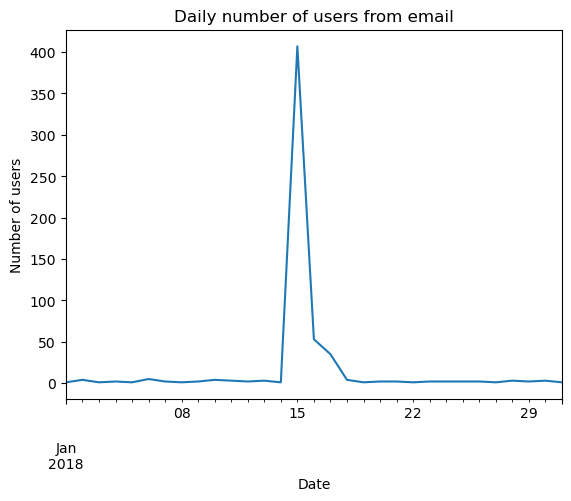

In [15]:
email = marketing[marketing['marketing_channel'] == "Email"]

daily_users_email = email.groupby(['date_served'])['user_id'].nunique()

# Plot the series daily_users_email
daily_users_email.plot()

# Annotate the plot
plt.title('Daily number of users from email')
plt.xlabel('Date')
plt.ylabel('Number of users')

# Show the plot
plt.show()

This confirms that an email campaign was responsible for the large mid-month spike.

---

## Exploratory Analysis & Summary Statistics <a class="anchor" id="eass"></a>

### Marketing Metrics

Was the campaign successful?

Campaign success is best measured with conversion rate and retention rate. That is the percentage of users who made a sale proportional to the total users you marketed to, and more importantly the percentage of those users who stayed clients for at least a month (your timeframe may be different according to your business model and idea of success).



### Findings
* Conversion rate = 14.09 %
* Retention rate = 65.83 %

Are these rates good? It depends on the company and industry. You can look at other companies in your industry. However, the best measure is against yourself. Look at your own historical data for comparison to see if you're improving.

### Conversion rate 

= number of users who converted divided by the total number of users marketed to.

In [16]:
# Slice the DataFrame to include only the rows where 'converted' equals True and then count the unique 'user_id's using "nunique()" method. 
subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()

# Next, calculate the total number of users marketed to by counting all the unique user IDs in your dataset. 
total_unique = marketing['user_id'].nunique()

# Now that you have the total number of users and users who subscribed, calculate conversion rate by dividing subscribers by total.
conv_rate = subscribers/total_unique

# Print the percentage rounded to 2 decimal places
print(round(conv_rate*100, 2), '%')

14.09 %


### Retention rate
= number of users who remain subscribed divided by the total number of users who converted.

In [17]:
# Slice the DataFrame to include only rows where the user was retained, that is, where 'is_retained' equals True and count the unique 'user_id's. 
retained = marketing[marketing['is_retained'] == True]['user_id'].nunique()

# We can reuse our subscribers calculation from the conversion rate calculation, as the number of total users who originally subscribed remains the same. 
subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()

# Divide the number of users who were retained by the number of users who subscribed to calculate the retention rate.
reten_rate = retained/subscribers

# Print the percentage rounded to 2 decimal places
print(round(reten_rate*100, 2), '%')

65.83 %


## Segmentation <a class="anchor" id="seg"></a>

This involves dividing up your audiences by specific characteristics, such as demographics, location, interactions with your business, channels used, etc or dividing your makreting efforts by channel, date, days of the week. This is very important when analysing marketing campaign success.

#### Why is this important?
As above, your conversion rate for all your marketing efforts for January is 14.09%. You might think this great. However, this is a broad metric and is not indicative of how individual campaigns or channels performed in different customer segments, on different periods of the month or days of the week. It's possible when you dig deeper that your campaign was very effective on younger age groups but older age groups did not appreciate it. If you continue to market based on your overall conversion rate, you might eventually completely lose touch with your older customer base.

In contrast, if you find your overall conversion rate low, a deeper analysis of segmented audiences might uncover that your campaign was extremely effective for German speakers. Instead of writing your campaign off as a failure, you've actually discovered how to market to your German customer base and can target them effectively in future campaigns.

Segmenting might also reveal that some campaigns are underperforming, or that customers hardly ever subscribe over the weekend. This is powerful info that you can use to make your marketing efforts more effective.

### How many subscribers were gained by each channel? <a class="anchor" id="subs-channel-list"></a>

#### Findings:
* Email:        161
* Facebook:     221
* **House Ads:    298**
* Instagram:    232
* Push:          77

#### Calculations:
Instead of doing each channel one-by-one, use the groupby() method to analyze and calculate statistics for multiple sub-segments in your data. 

First, subset the data to include only the customers who `converted` and then group by `subscribing_channel`. Lastly, we count the number of unique user ids to find the total number of subscribed customers per channel.


In [18]:
# Slice the DataFrame by 'converted' is True, groupby 'subscribing_channel, and count unique 'user_id'
channel_subscribers = marketing[marketing['converted'] == True].groupby(['subscribing_channel'])['user_id'].nunique()

# View the results
channel_subscribers

subscribing_channel
Email        161
Facebook     221
House Ads    298
Instagram    232
Push          77
Name: user_id, dtype: int64

### How many customers did each channel retain? <a class="anchor" id="cust-channel-retain"></a>

#### Findings:
* Email:        141
* Facebook:     152
* **House Ads:    173**
* Instagram:    158
* Push:          54

#### Calculations:

In [19]:
# Slice the DataFrame by 'is_retained' is True, groupby 'subscribing_channel, and count unique 'user_id'
channel_retained = marketing[marketing['is_retained'] == True].groupby(['subscribing_channel'])['user_id'].nunique()

# View the results
channel_retained

subscribing_channel
Email        141
Facebook     152
House Ads    173
Instagram    158
Push          54
Name: user_id, dtype: int64

### What are the conversions rates for each channel? <a class="anchor" id="conv-rate-channel-list"></a>

#### Findings:
* **Email:        29.11 %**
* Facebook:     12.57 %
* **House Ads:    7.51 %**
* Instagram:    13.33 %
* **Push:          7.92 %**

#### Insights:
Overall conversion rate for all channels in Jan was 14.09 %. As you can see, the Email rate is just over twice that, while Push and House Ads is almost half. This is a more accurate picture of campaign performance.

#### Calculations:

In [20]:
# Calculate total unique users marketed to by channel: group the marketing DataFrame by 'marketing_channel, and count unique 'user_id'
channel_total_unique = marketing.groupby(['marketing_channel'])['user_id'].nunique()

channel_total_unique

marketing_channel
Email         553
Facebook     1758
House Ads    3968
Instagram    1740
Push          972
Name: user_id, dtype: int64

In [21]:
# Slice the DataFrame by 'converted' is True, groupby 'subscribing_channel, and count unique 'user_id'
channel_subscribers = marketing[marketing['converted'] == True].groupby(['subscribing_channel'])['user_id'].nunique()

# Calculate conversion rates for each channel by dividing channel_subscribers by total subscribers
channel_conversion_rate = (channel_subscribers/channel_total_unique)

# View retention percentages rounded to two decimals
round(channel_conversion_rate*100, 2)

subscribing_channel
Email        29.11
Facebook     12.57
House Ads     7.51
Instagram    13.33
Push          7.92
Name: user_id, dtype: float64

### What are the retention rates for each channel? <a class="anchor" id="reten-rate-channel-list"></a>

#### Findings:
* **Email:        87.58 %**
* Facebook:     68.78 %
* **House Ads:    58.05 %**
* Instagram:    68.10 %
* Push:        70.13 %

#### Insights:
Overall retention rate for all channels for Jan was 65.83 %. As you can see, the same as the conversion rates above, Email far outperformed the average retention rate and House Ads has the lowest retention rate.

#### Calculations:

In [22]:
# Calculate retention rates for each channel by dividing channel_retained by channel_subs
channel_retention_rate = (channel_retained/channel_subscribers)

# View retention percentages rounded to two decimals
round(channel_retention_rate*100, 2)

subscribing_channel
Email        87.58
Facebook     68.78
House Ads    58.05
Instagram    68.10
Push         70.13
Name: user_id, dtype: float64

### What is the conversion rate for English speakers? <a class="anchor" id="conv-rate-eng"></a>

#### Findings:
English speaker conversion rate: 13.13 %, which is slightly below to the overall conversion rate.

#### Calculations:

In [23]:
# Slice the marketing DataFrame to isolate English speakers
english_speakers = marketing[marketing['language_displayed'] == "English"]

# Calculate the total number of English speaking users
total_english_speakers = english_speakers['user_id'].nunique()

# Calculate the number of English speakers who converted
english_subscribers = english_speakers[english_speakers['converted'] == True]['user_id'].nunique()

# Calculate conversion rate
english_conversion_rate = english_subscribers/total_english_speakers

# View retention percentages rounded to two decimals
print('English speaker conversion rate:', round(english_conversion_rate*100, 2), '%')

English speaker conversion rate: 13.13 %


### How does the English conversion rate compare against the other 3 languages?

#### Findings:
* Arabic:     50.00 %
* English:    13.13 %
* German:     71.62 %
* Spanish:    20.00 %

#### Calculations:

In [24]:
# Get total unique users grouped by 'language_displayed'
language_total_unique = marketing.groupby(['language_displayed'])['user_id'].nunique()

# Get total unique subscribers grouped by 'language_displayed'
language_subscribers = marketing[marketing['converted'] == True].groupby(['language_displayed'])['user_id'].nunique()

# Calculate conversion rate for all languages
language_conversion_rate = language_subscribers/language_total_unique

# View conversion rate by language rounded to two decimals
round(language_conversion_rate*100, 2)

language_displayed
Arabic     50.00
English    13.13
German     71.62
Spanish    20.00
Name: user_id, dtype: float64

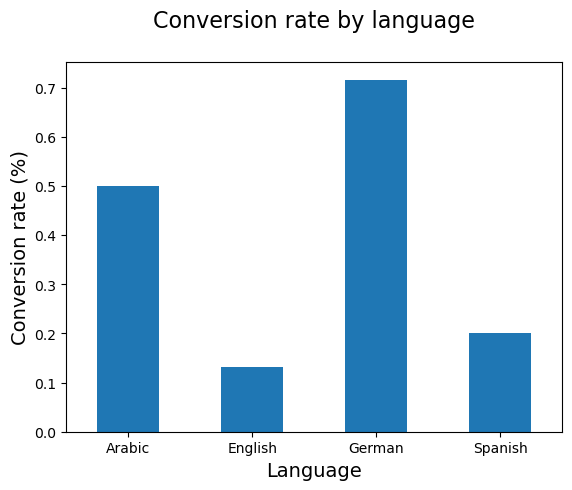

In [25]:
# Create a bar chart visualising language conversion rates
language_conversion_rate.plot(kind = 'bar')

# Annotate it
plt.title('Conversion rate by language\n', size=16)
plt.xlabel('Language', size=14)
plt.ylabel('Conversion rate (%)', size=14)

# Rotate Language labels by 45 degrees to increase legibility
plt.xticks(rotation = 0)

# Show the plot
plt.show()

#### Insights:
In the bar chart above, English and Spanish are considerably lower than German and Arabic. Since, English makes up the majority of your user base, this warrants further in investigation. <a class="anchor" id="conv-rate-lang"></a>

Next, visualise daily perfomance to help uncover problems and valuable insights. 

#### Calculations:

In [26]:
# First, plot the overall daily conversion rate for a baseline.
# Get daily subscriptions
daily_subscribers = marketing[marketing['converted'] == True].groupby(['date_served'])['user_id'].nunique()

# Calculate daily conversion rate
daily_conversion_rate = daily_subscribers/daily_users

round(daily_conversion_rate*100, 2)

date_served
2018-01-01     9.94
2018-01-02     9.89
2018-01-03    10.34
2018-01-04    10.84
2018-01-05    12.54
2018-01-06    11.36
2018-01-07    14.18
2018-01-08    11.54
2018-01-09    12.50
2018-01-10    11.87
2018-01-11     8.06
2018-01-12     7.64
2018-01-13     8.50
2018-01-14     8.52
2018-01-15    11.34
2018-01-16    25.52
2018-01-17    21.95
2018-01-18     9.12
2018-01-19     5.90
2018-01-20     6.75
2018-01-21     8.73
2018-01-22    12.36
2018-01-23    12.21
2018-01-24    11.58
2018-01-25    12.50
2018-01-26     9.01
2018-01-27     6.56
2018-01-28     6.25
2018-01-29     5.96
2018-01-30     6.62
2018-01-31     5.29
Name: user_id, dtype: float64

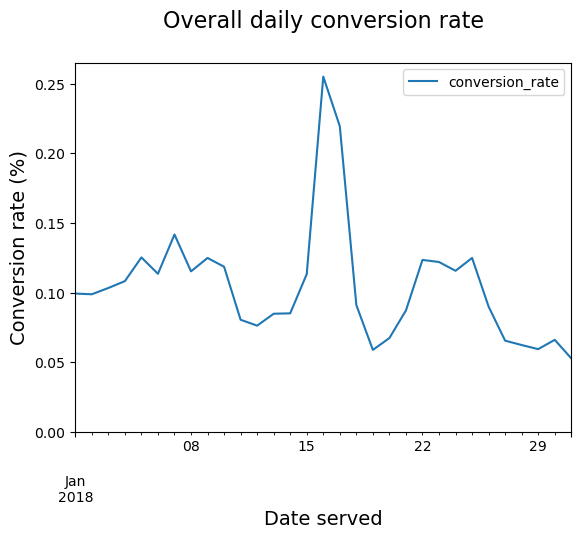

In [27]:
# Prep data for visualisation:
# Reset index to turn the results in a DataFrame
daily_conversion_rate = pd.DataFrame(daily_conversion_rate.reset_index())

# Rename columns
daily_conversion_rate.columns = ['date_served', 'conversion_rate']

# Create a bar chart visualising language conversion rates
daily_conversion_rate.plot('date_served', 'conversion_rate')

# Annotate it
plt.title('Overall daily conversion rate\n', size=16)
plt.xlabel('Date served', size=14)
plt.ylabel('Conversion rate (%)', size=14)

# Set the y-axis to begin at 0
plt.ylim(0)

# Show the plot
plt.show()

#### Insights:
The line plot above shows conversion rate drops on the 11th and continues on a downward trend for the much of rest of Jan, with the exception of the email blast in the middle of the month. <a class="anchor" id="overall-daily-conv-plot"></a>

Next, calulate daily retention rate. 

#### Calculations:

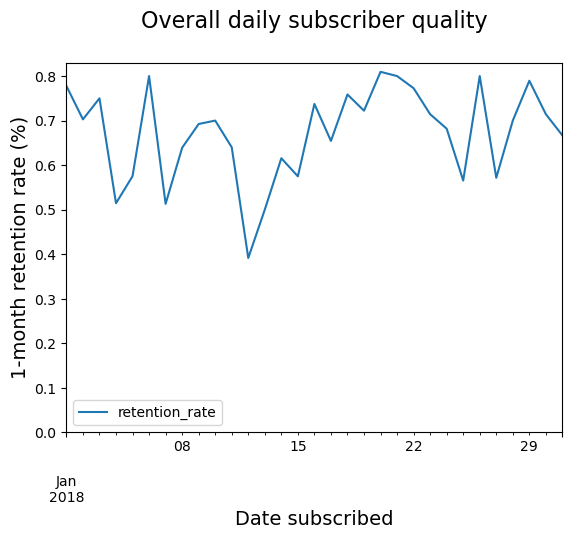

In [28]:
# Calculate daily retention rate
## Get retained grouped by 'date_subscribed'
retained_day_sub = marketing[marketing['is_retained'] == True].groupby(['date_subscribed'])['user_id'].nunique()

# Calculate daily conversion rate
daily_retention_rate = retained_day_sub/daily_subscribers

# Prep data for visualisation:
# Reset index to turn the results in a DataFrame
daily_retention_rate = pd.DataFrame(daily_retention_rate.reset_index())

# Rename columns
daily_retention_rate.columns = ['date_subscribed', 'retention_rate']

# Create a bar chart visualising language conversion rates
daily_retention_rate.plot('date_subscribed', 'retention_rate')

# Annotate it
plt.title('Overall daily subscriber quality\n', size=16)
plt.xlabel('Date subscribed', size=14)
plt.ylabel('1-month retention rate (%)', size=14)

# Set the y-axis to begin at 0
plt.ylim(0)

# Show the plot
plt.show()

#### Insights:
The line plot above shows that retention has a substantial recovery and climb during the middle of the month, coinciding with conversion rate spike for the email blast. <a class="anchor" id="overall-daily-reten"></a>

Let's dig deeper, and see daily trends for language segments. 

#### Calculations:

In [29]:
# Count users daily users for ecah preferred language.
daily_pref_lang = marketing.groupby(['date_served', 'language_preferred'])['user_id'].count()

daily_pref_lang

date_served  language_preferred
2018-01-01   Arabic                  4
             English               355
             German                  5
             Spanish                11
2018-01-02   Arabic                  4
                                  ... 
2018-01-30   Spanish                19
2018-01-31   Arabic                  8
             English               317
             German                  5
             Spanish                17
Name: user_id, Length: 121, dtype: int64

It can be easier to manipulate the data when you have a DataFrame. Use the unstack() method to transform your data such that each preferred language becomes a column. 

Since preferred_language is the second index, we set the level argument to 1, indicating that you want to unstack the second index. Remember, the first index is represented with 0, and the second with 1.


In [30]:
# Turn it into a DataFrame and unstack
daily_pref_lang = pd.DataFrame(daily_pref_lang.unstack(level=1))

daily_pref_lang.head()

language_preferred,Arabic,English,German,Spanish
date_served,,,,
2018-01-01,4.0,355.0,5.0,11.0
2018-01-02,4.0,397.0,6.0,10.0
2018-01-03,3.0,374.0,3.0,8.0
2018-01-04,2.0,318.0,2.0,14.0
2018-01-05,1.0,314.0,2.0,14.0


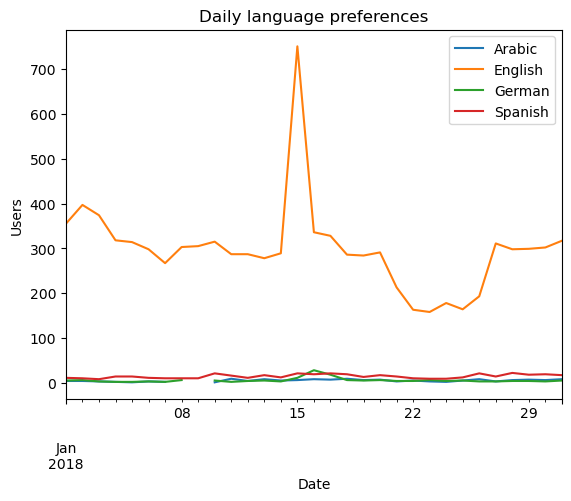

In [31]:
# Plot daily preferred language
daily_pref_lang.plot()
plt.title('Daily language preferences')
plt.xlabel('Date')
plt.ylabel('Users')

# Include a legend for each language. The loc argument determines the location of the legend and to get the correct labels; set the labels argument to the column names. The column names can be obtained by chaining the columns and values attributes.
plt.legend(loc = 'upper right', labels = daily_pref_lang.columns.values)
plt.show()

### Insights:
The line plot above confirms English is the most preferred language. <a class="anchor" id="daily-lang-pref"></a>

### Are marketing channels reaching all age groups?


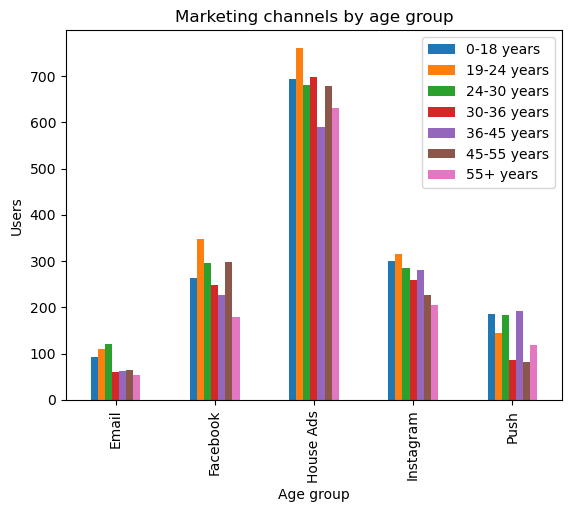

In [32]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])['user_id'].count()

# Unstack channel_age and transform it into a DataFrame
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))

# Plot channel_age
channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age group')
plt.ylabel('Users')

# Add a legend to the plot
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values)
plt.show()

### Insights:
The grouped bar chart above shows that email is not reaching older age groups, and Facebook is not reaching many people over 55, and Push is not reaching 30-36 or 45-55. <a class="anchor" id="channel-age"></a>


---

## Conversion Attribution by Segments <a class="anchor" id="conv-attr-seg"></a>

Deep analysis of conversions by date, age group, channel, language.

### Functions
Calculating conversions for so many segments is very repetitive work. Build a conversion function to calculate conversion rate across any sub-segment you want on the fly.

#### Conversion rate function
This conversion function takes a DataFrame and list of column names and outputs the conversion rate across the column(s):

Isolate rows in the user inputted `dataframe` where users were converted, then group by the list of user inputted `column_names` and count the number of unique `'converted'` users.

Group the user inputted dataframe by the list of user inputted `column_names` and calculate the total number of users.

Fill any missing values in `conversion_rate` with 0.

In [33]:
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()

    # Total number users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()   
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate*100

#### Plot conversion function
1. Create a for loop for each column in the dataframe.
2. Plot a line chart of the column by the DataFrame's index.
3. Show the plot.

In [34]:
def plot_conv(dataframe):
    for column in dataframe:
        # Plot column by dataframe's index
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', 
                  size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation = 45)
        plt.ylim(0)
        
        # Show plot
        plt.show()  
        plt.clf()

#### Retention function

In [35]:
def retention_rate(dataframe, column_names):
    # Total number of unique retained users grouped by column_names
    column_retained = dataframe[dataframe['is_retained'] == True].groupby(column_names)['user_id'].nunique()

    # Total number of converted users
    column_conv = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()   
    
    # Calculate retention rate 
    retention_rate = column_retained/column_conv
    
    return retention_rate*100

### Day of week conversion trends <a class="anchor" id="dow"></a>
Which days of the week are users most likely to convert for each channel and stay subscribed?

#### Findings & insights:
Channels:
* Email: **Tues & Wed** __ ~20% variation between min and max
* Facebook: **Fri & Mon** __  ~20% variation
* House Ads: **Mon & Sun**  __ ~15% variation
* Instagram: **Fri** __ ~10% variation
* Push: **Wed & Thurs** __ avoid Fri! It's more than 30% lower than the max

Retention:

There does appear to be some relationship where retention is lower if users subscribe later in the week, but this difference is small and is likely indicative of something else, such as sending more emails on the weekend which converts lower intent users. 

This is all to say, weekday fluctuations are common and do not necessarily merit raising a red flag even if you see a consistent pattern, but it might mean modifying when you attempt to market to customers most heavily.

#### Calculations:
Plots below:
0 represents Monday, 6 represents Sunday.

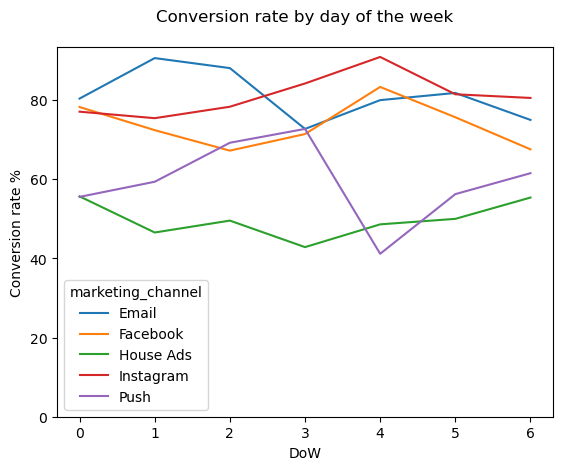

In [36]:
channel_DoW_conversion = conversion_rate(marketing, ['DoW', 'marketing_channel'])

channel_DoW_conversion = pd.DataFrame(channel_DoW_conversion.unstack(level=1))

# Plot by day of week
channel_DoW_conversion.plot()
plt.title('Conversion rate by day of the week\n')
plt.ylabel('Conversion rate %')
plt.ylim(0)
plt.show()

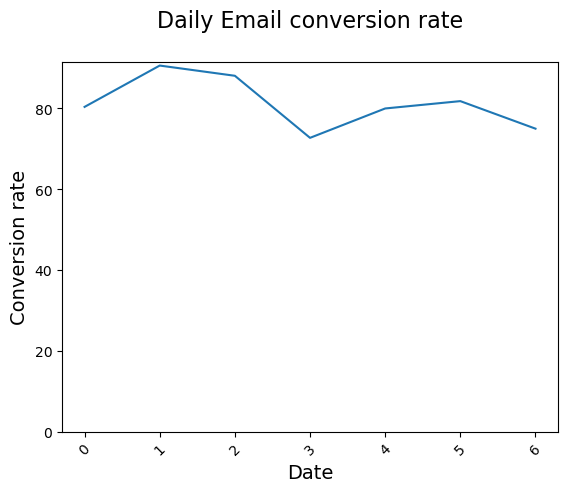

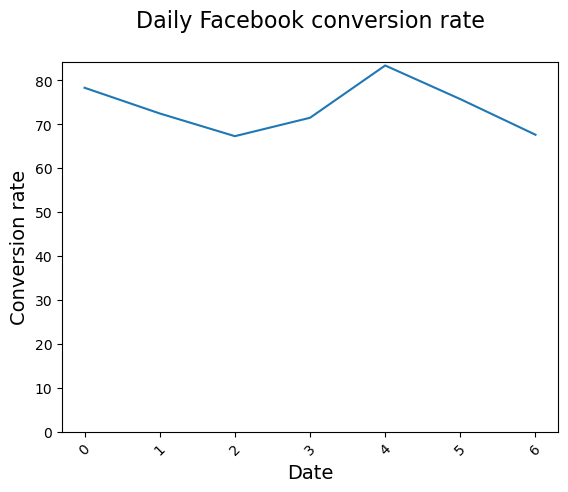

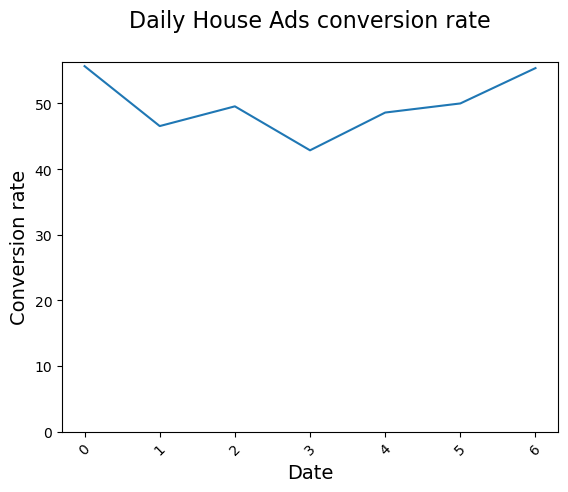

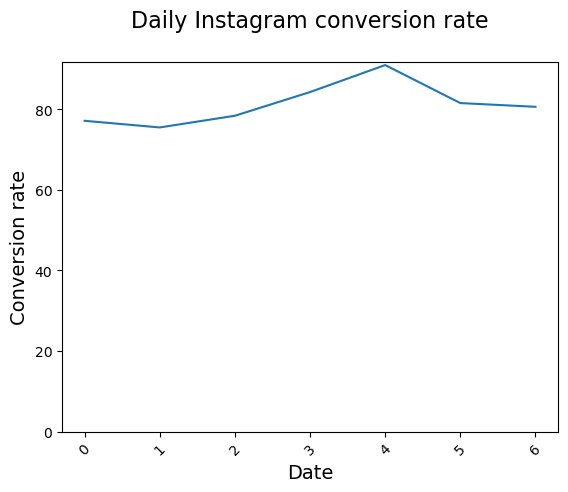

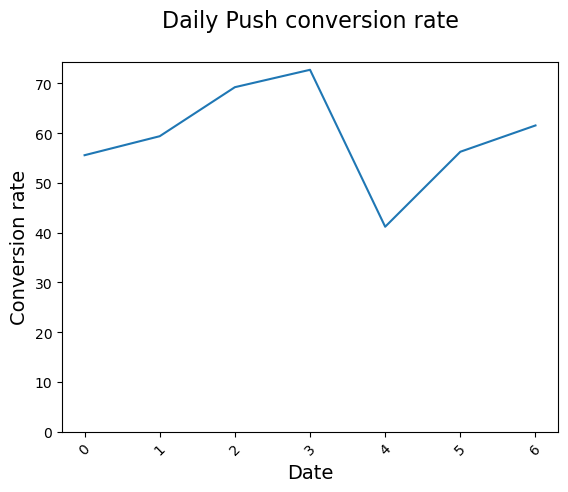

<Figure size 640x480 with 0 Axes>

In [37]:
channel_DoW_conversion = conversion_rate(marketing, ['DoW', 'marketing_channel'])

channel_DoW_conversion = pd.DataFrame(channel_DoW_conversion.unstack(level=1))

# Plot by day of week
plot_conv(channel_DoW_conversion)

#### Retention rate by day of week

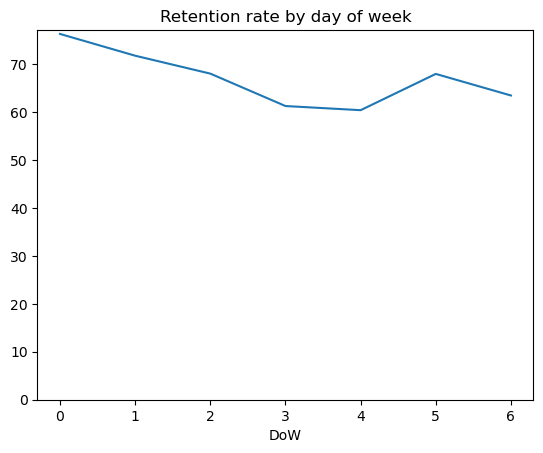

In [38]:
DoW_retention = retention_rate(marketing, ['DoW'])

# Plot by day of week
DoW_retention.plot()
plt.title('Retention rate by day of week')
plt.ylim(0)
plt.show()

#### Insights: <a class="anchor" id="reten-dow"></a>
In the line plot above, 0 represents Monday, 6 represents Sunday. 

As you can see, there does appear to be some relationship where retention is lower if users subscribe later in the week, but this difference is small and is likely indicative of something else, such as sending more emails on the weekend which converts lower intent users. 

This is all to say, weekday fluctuations are common and do not necessarily merit raising a red flag even if you see a consistent pattern, but it might mean modifying when you attempt to market to customers most heavily.


### Daily Conversion rates by age group <a class="anchor" id="daily-conv-age"></a>

date_served  age_group  
2018-01-01   0-18 years     15.517241
             19-24 years    19.672131
             24-30 years    10.526316
             30-36 years     4.081633
             36-45 years     4.255319
                              ...    
2018-01-31   24-30 years     5.769231
             30-36 years     0.000000
             36-45 years     3.508772
             45-55 years     2.325581
             55+ years       2.631579
Name: user_id, Length: 217, dtype: float64


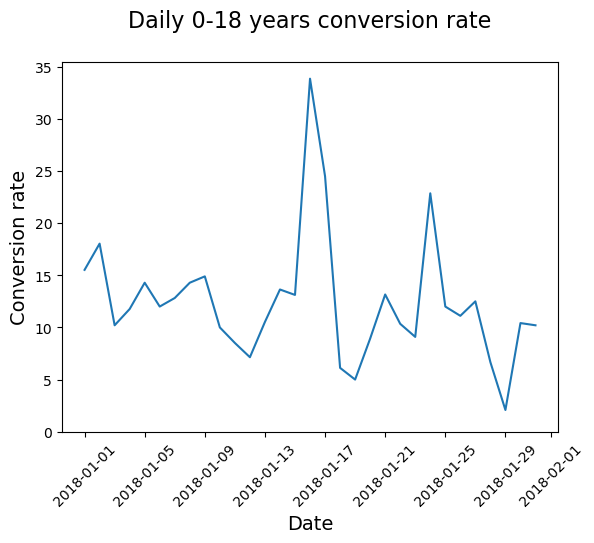

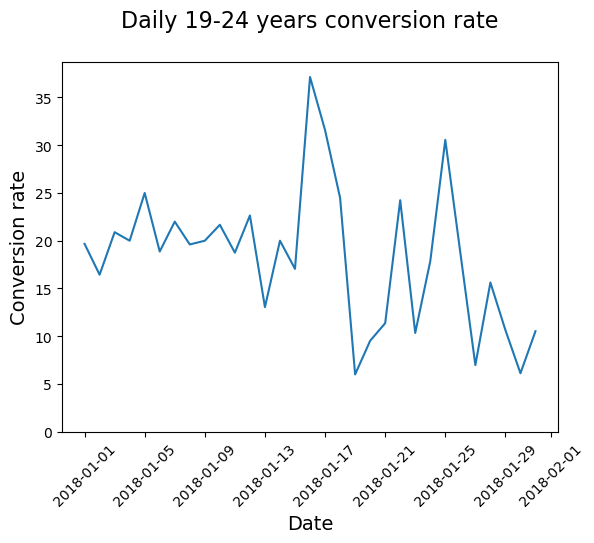

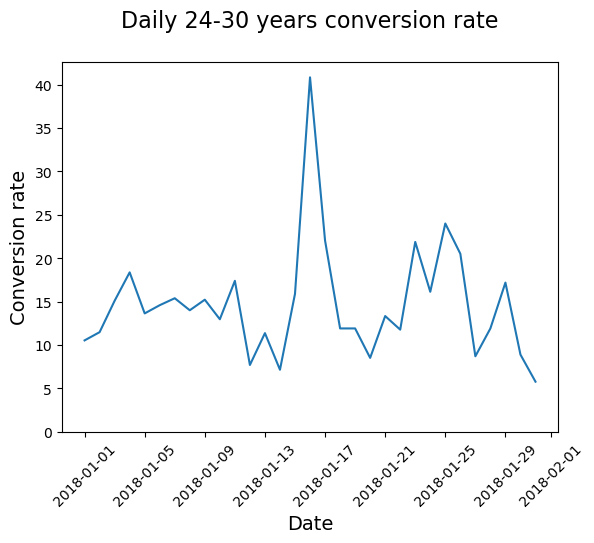

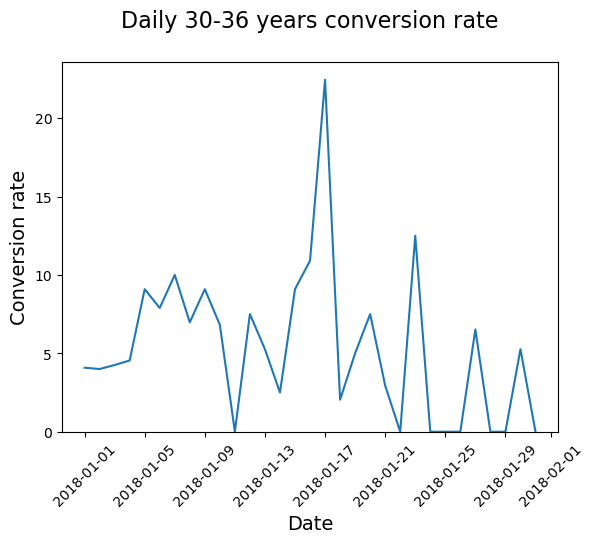

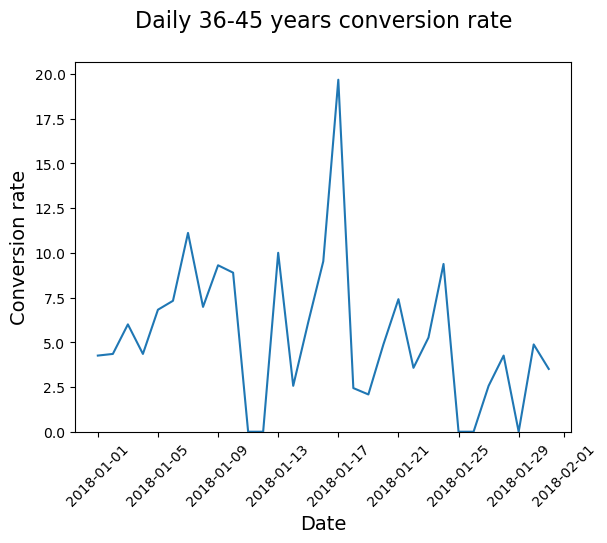

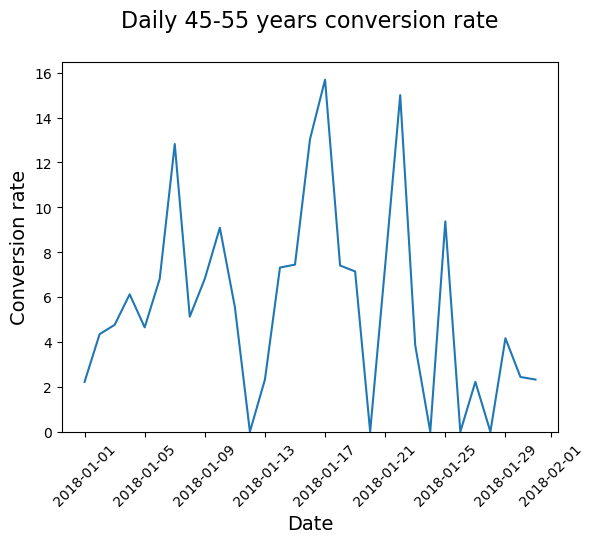

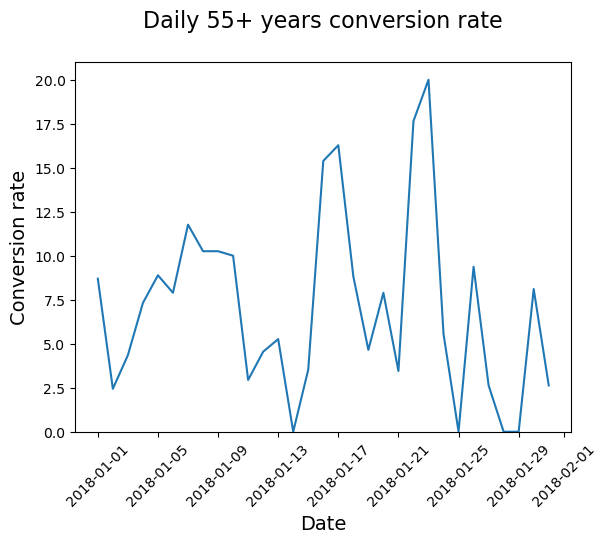

<Figure size 640x480 with 0 Axes>

In [39]:
# Calculate conversion rate by date and age_group
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])
print(age_group_conv)

# Unstack and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Visualize conversion by age_group
plot_conv(age_group_df)

### Daily conversion rate by language

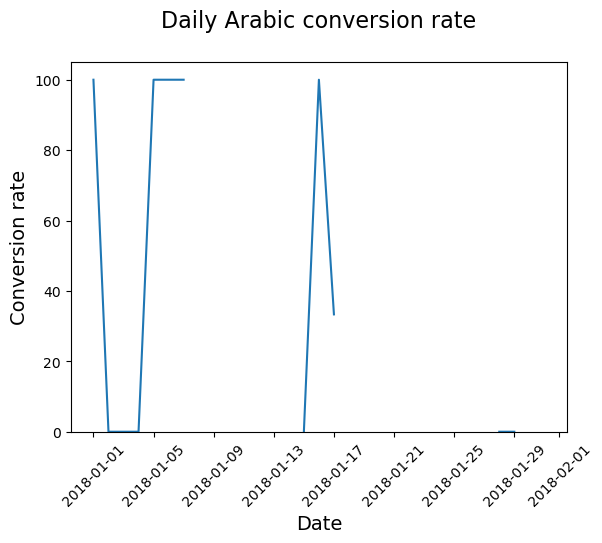

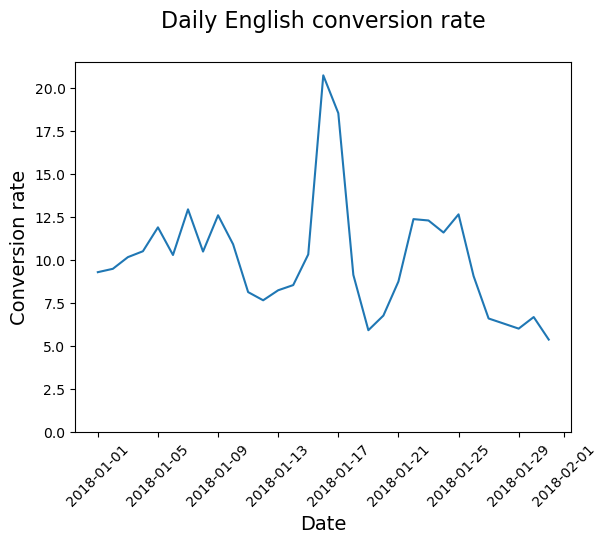

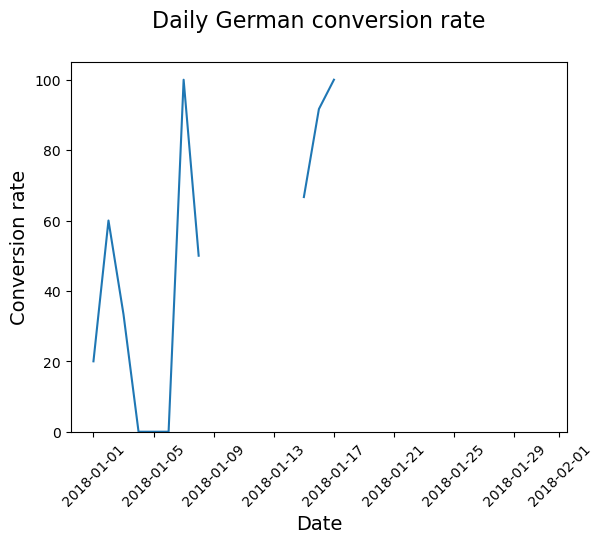

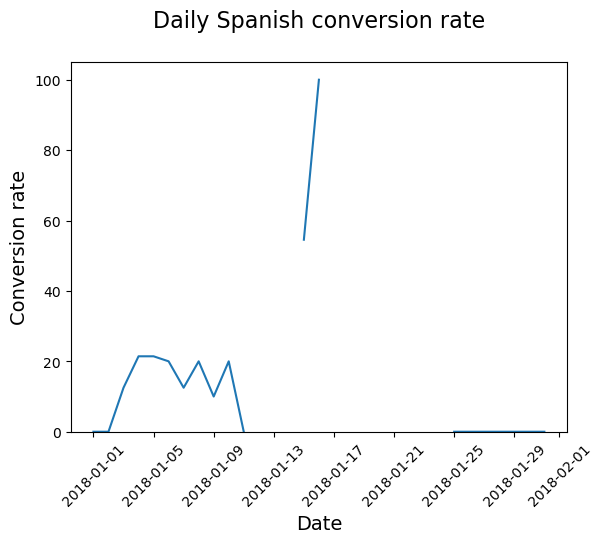

<Figure size 640x480 with 0 Axes>

In [40]:
# Calculate conversion rate by date served and channel
daily_conv_lang = conversion_rate(marketing, ['date_served', 
                                                 'language_displayed'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_lang = pd.DataFrame(daily_conv_lang.unstack(level = 1))

# Plot results of daily_conv_channel
plot_conv(daily_conv_lang)


#### Insights: <a class="anchor" id="daily-conv-lang"></a>
As you can see, English is the only language that has a conversion rate throughout the whole month, with major gaps in the others. 

These are inconsistencies. 

Segementing by channel might give further insight.

### Daily conversion rate by channel

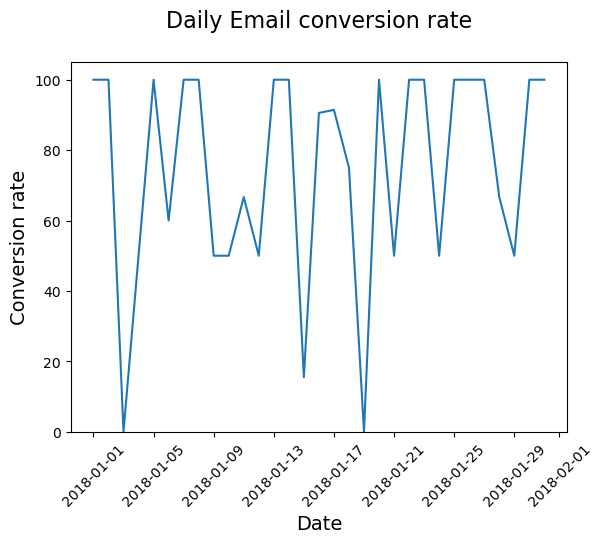

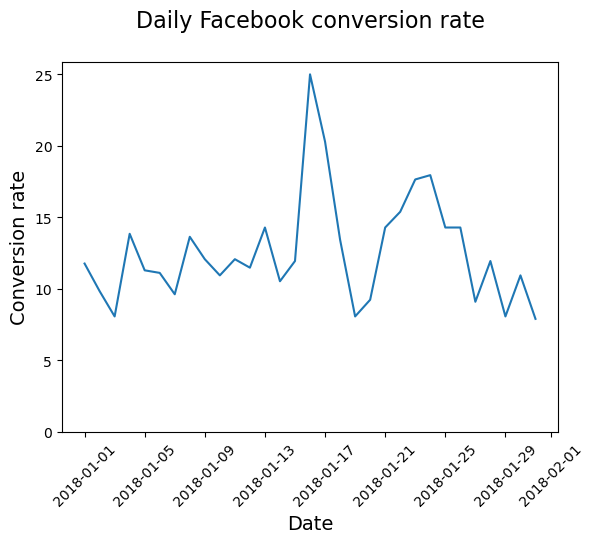

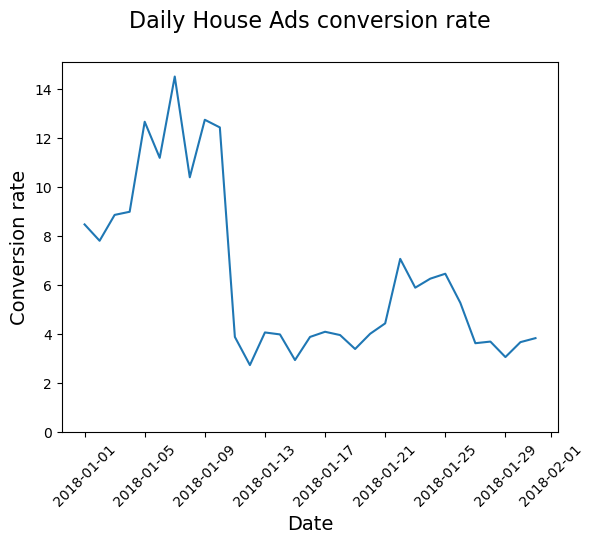

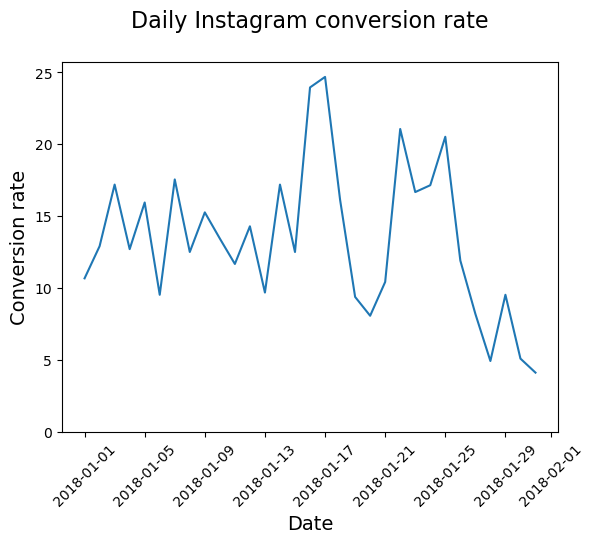

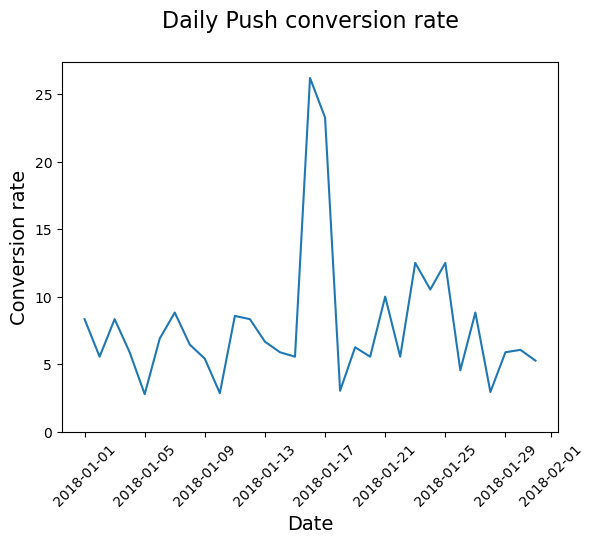

<Figure size 640x480 with 0 Axes>

In [41]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plot_conv(daily_conv_channel)

#### Insights: <a class="anchor" id="ads-drop"></a>
There was a sudden considerable decrease in conversion rate with House Ads on the 11th. This is quite the inconsistency and might be related to the language issue.

---

## Inconsistencies <a class="anchor" id="incon"></a>

### Identifying the cause of inconsistencies <a class="anchor" id="cause"></a>

House ads conversion by language
Looking at eariler findings of the day of week trends by channel, you ruled out natural fluctuations across the day of the week a user saw House Ads as the cause for decreasing house ads conversion. Next step would be to look at House Ads conversion by language over time.

#### House Ads daily conversion rate by language

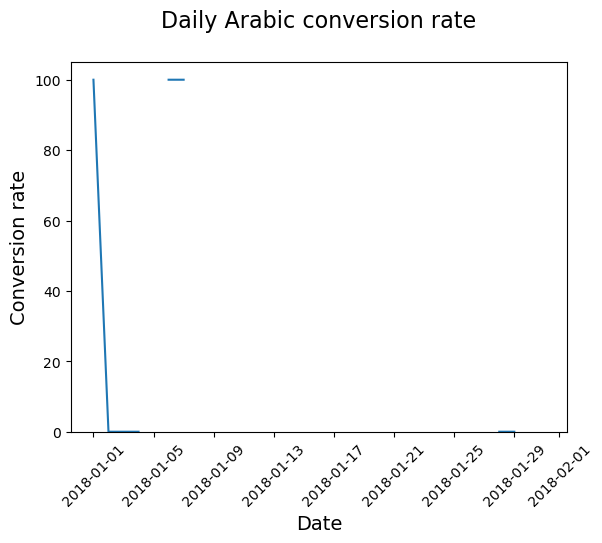

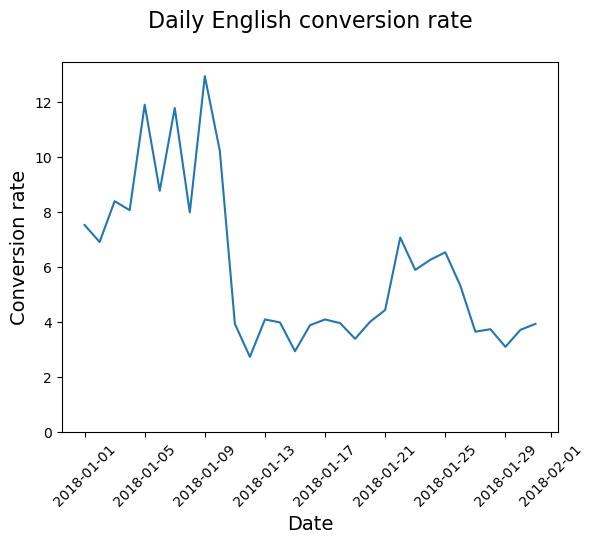

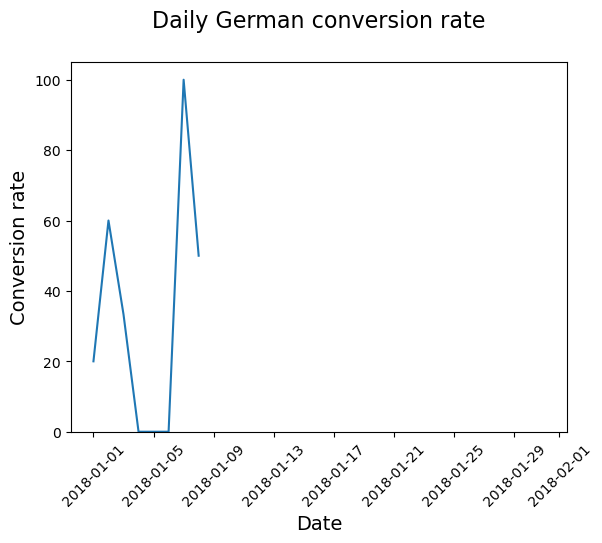

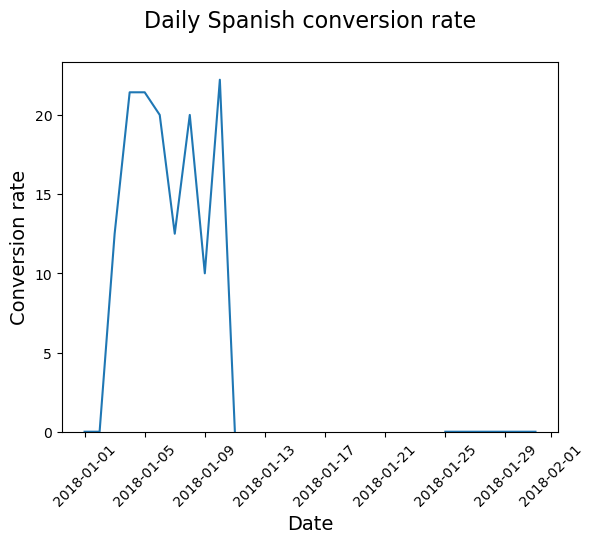

<Figure size 640x480 with 0 Axes>

In [42]:
# Isolate the rows where marketing channel is "House Ads"
house_ads = marketing[marketing['marketing_channel'] == 'House Ads']

# Calculate conversion by date served, and language displayed
daily_conv_lang_ads = conversion_rate(house_ads, ['date_served', 'language_displayed'])

# Unstack daily_conv_lang_ads
daily_conv_lang_ads_df = pd.DataFrame(daily_conv_lang_ads.unstack(level=1))

# Use your plot function to display results
plot_conv(daily_conv_lang_ads_df)

#### Insights: <a class="anchor" id="eng_conv_drop"></a>
The line plot above shows the House Ads English conversion rate drops around the 11th, and there do not appear to be ads served in other languages for a two week period. This confirms that the problem lies with preferred languages for House Ads.
 
Next, find out whether ads were served in the language they prefer.

In [43]:
# Use np.where() to create a new column in house_ads called 'is_correct_lang' whose values are 'Yes' if 'language_displayed' is equal to 'language_preferred' and 'No' otherwise.
house_ads['is_correct_lang'] = np.where(house_ads['language_preferred'] == house_ads['language_displayed'],'Yes', 'No')

# Groupby 'date_served' and 'is_correct_lang' to get a daily count of the ads served.
language_check = house_ads.groupby(['date_served','is_correct_lang'])['is_correct_lang'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# View results
language_check_df

C:\Users\michel\AppData\Local\Temp\ipykernel_4892\966762667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(house_ads['language_preferred'] == house_ads['language_displayed'],'Yes', 'No')


is_correct_lang,No,Yes
date_served,,
2018-01-01,2.0,189.0
2018-01-02,3.0,247.0
2018-01-03,0.0,220.0
2018-01-04,0.0,168.0
2018-01-05,0.0,160.0
2018-01-06,1.0,151.0
2018-01-07,2.0,130.0
2018-01-08,0.0,154.0
2018-01-09,0.0,157.0


#### Insights:
The list above confirms ads were not being served in a user's preferred language from the 11th, which is the same day the House Ads conversion rate dropped.


Next, calculate what percentage of users were not being served ads in the correct language and plot your results.

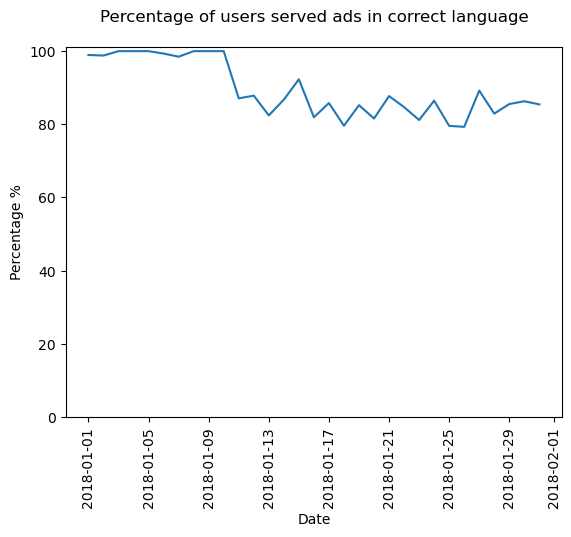

In [44]:
# Add a 'pct' column to 'language_check_df' which divides the count where language is correct by the row sum extracted using the .sum() method while setting the axis argument to 1.
language_check_df['pct'] = (language_check_df['Yes']/language_check_df.sum(axis=1))*100

# Plot and show your results using language_check_df.index.values
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.title('Percentage of users served ads in correct language\n')
plt.xlabel('Date')
plt.ylabel('Percentage %')
plt.ylim(0)
plt.xticks(rotation = 90)
plt.show()

#### Insights: <a class="anchor" id="ads_correct_lang"></a>
The line plot above confirms that house ads have been underperforming from the 11th due to ads being served in English rather than each user's preferred language.

Next, calculate how many subscribers were lost as a result of this error.

### Calculate the impact of the error <a class="anchor" id="impact"></a>

#### Findings:
Number of lost subscribers: **32.14**

#### 1. Calculate language indexes against English
By using the pre-error conversion rate for each language, you can rate their performnace in comparison to English. With these indexes, you'll be able to calculate an estimate of the number of sucbscribers you could've earned had there not been a campaign error.

#### Findings: 
* **Spanish index**: 1.6819248826291078
* **Arabic index**: 5.045774647887324
* **German index**: 4.485133020344288

#### Insights:
This means that Spanish-speaking users typically convert 1.7 times the rate of English speakers and Arabic and German speakers convert at about 4-5 times the rate compared to English speakers.

#### Calculations:
Index all other languages' conversion rates to English during the period where the ads were running in the correct language for each user.

In [45]:
# Caclulate the pre-error conversion rate:
# Create a new DataFrame, house_ads_bug, that contains only the rows from house_ads with 'date_served' prior to '2018-01-11'.
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']

# Use your conversion_rate() function on the house_ads_bug DataFrame and the 'language_displayed' column.
lang_conv = conversion_rate(house_ads_bug, ['language_displayed'])

# Index other language conversion rate against English: Using the appropriate row, divide the Spanish, Arabic and German columns of lang_conv by the English column.
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.6819248826291078
Arabic index: 5.045774647887324
German index: 4.485133020344288


#### 2. Calculate actual daily conversions
For each language, calculate the total number of users and actual conversions on each day.

In [46]:
# Group house_ads by 'date_served' and 'language_preferred'. Use a dictionary within a call to .agg() to calculate the number of unique users and sum the number of converted users.
language_conversion = house_ads.groupby(['date_served','language_preferred']).agg({'user_id':'nunique', 'converted':'sum'})

# Unstack converted at level = 1
language_conversion = pd.DataFrame(language_conversion.unstack(level=1))

language_conversion.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                            
language_preferred Spanish  
date_served                 
2018-01-01             0.0  
2018-01-02             0.0  
2018-01-03             1.0  
2018-01-04             3.0  
2018-01-05             3.0

#### 3. Estimate what daily conversion rates should've been if users were served the correct language
To understand the true impact of the bug, it is crucial to determine how many subscribers you would have expected had there been no language error. This is crucial to understanding the scale of the problem and how important it is to prevent this kind of error in the future.


In [47]:
# Create English conversion rate column for affected period: Use .loc to create the column actual_english_conv_rate in converted with the English conversion rate between '2018-01-11' and '2018-01-31'
language_conversion['actual_english_conv_rate'] = language_conversion.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language by multiplying actual_english_conv_rate by each language index (spanish_index, arabic_index or german_index)
language_conversion['expected_spanish_rate'] = language_conversion['actual_english_conv_rate']*spanish_index
language_conversion['expected_arabic_rate'] = language_conversion['actual_english_conv_rate']*arabic_index
language_conversion['expected_german_rate'] = language_conversion['actual_english_conv_rate']*german_index

# Multiply each language's expected conversion rate by the number of users who should have received House Ads (total ads served)
language_conversion['expected_spanish_conv'] = language_conversion['expected_spanish_rate']*language_conversion[('user_id','Spanish')]/100
language_conversion['expected_arabic_conv'] = language_conversion['expected_arabic_rate']*language_conversion[('user_id','Arabic')]/100
language_conversion['expected_german_conv'] = language_conversion['expected_german_rate']*language_conversion[('user_id','German')]/100

#### 4. Calculate the number of lost subscribers

In [48]:
# Use .loc to slice only the relevant dates for the error period
error_period = language_conversion.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = error_period['expected_spanish_conv'].sum() + error_period['expected_arabic_conv'].sum() + error_period['expected_german_conv'].sum()

# Calculate how many subscribers we actually got
actual_subs = error_period[('converted','Spanish')].sum() + error_period[('converted','Arabic')].sum() +error_period[('converted','German')].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs
round(lost_subs, 2)

32.14

---